## Import packages


In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image
import os
import sys

sys.path.insert(0, "..")
from preprocess import VietnameseTextCleaner
from utils import dict_handler
from transforms import ImageTransform


matplotlib.style.use("ggplot")

## Paths


In [2]:
CUR_DIR = os.path.abspath(os.curdir)
METADATA_PATH = os.path.join(CUR_DIR, "../data/reintel2020/public_train.csv")
IMAGES_DIR = os.path.join(CUR_DIR, "../data/reintel2020/public_train_final_images/")
CACHE_DIR = "D:\\storage\\odl\\cache\\"
VNCORE_NLP_PATH = os.path.join(CUR_DIR, "../vncorenlp/")
STOPWORDS_PATH = os.path.join(CUR_DIR, "../stop_words/vietnamese-stopwords-dash.txt")

## Init Cleaner


In [3]:
cleaner = VietnameseTextCleaner(
    stopwords_path=STOPWORDS_PATH,
    vncorenlp_path=VNCORE_NLP_PATH,
    cur_dir=CUR_DIR,
)

## Read csv


In [4]:
df_train = pd.read_csv(METADATA_PATH)

## Fixing timestamp errors


In [5]:
# type errors
errors = []
for i in range(len(df_train["timestamp_post"])):
    try:
        float(df_train["timestamp_post"][i])
    except:
        errors.append(i)

In [6]:
# missing
missings = df_train[df_train.timestamp_post.isnull()].index.to_list()

In [7]:
# fill with mean
mean = (
    df_train[~df_train.index.isin(missings + errors)]["timestamp_post"]
    .astype(float)
    .mean()
)
df_train.loc[errors + missings, "timestamp_post"] = mean
df_train.timestamp_post = df_train.timestamp_post.astype(float)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4372 entries, 0 to 4371
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                4372 non-null   int64  
 1   user_name         4372 non-null   object 
 2   post_message      4371 non-null   object 
 3   timestamp_post    4372 non-null   float64
 4   num_like_post     4257 non-null   object 
 5   num_comment_post  4362 non-null   object 
 6   num_share_post    3647 non-null   object 
 7   label             4372 non-null   int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 273.4+ KB


## Sort by timestamp


In [8]:
df_sorted = df_train.sort_values("timestamp_post")

Preprocessing


In [9]:
dataset = [
    dict_handler(dict_object=record, cleaner=cleaner)
    for record in tqdm(df_sorted.to_dict("records"))
]

  0%|          | 0/4372 [00:00<?, ?it/s]

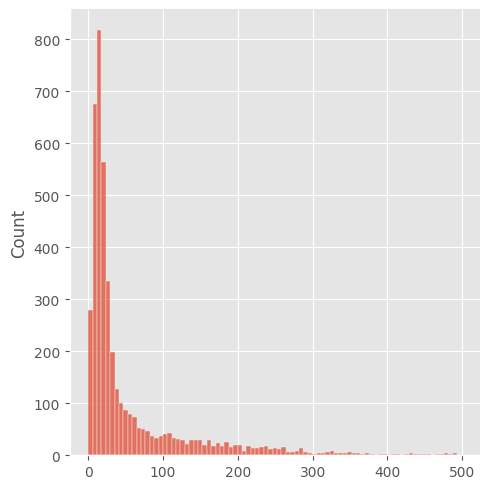

In [10]:
import seaborn as sns

sns.displot(
    data=[
        len(sample["post_message"].split())
        if len(sample["post_message"].split()) < 500
        else 0
        for sample in dataset
    ]
)

plt.show()

## Save dataset as cache


In [11]:
import torch

list_of_dicts = dataset  # List of dictionaries with data

# Divide the list into 5 sublists of roughly equal size
num_chunks = 5
chunk_size = -(-len(list_of_dicts) // num_chunks)  # Round up division
dict_chunks = [
    list_of_dicts[i : i + chunk_size] for i in range(0, len(list_of_dicts), chunk_size)
]


save_dir = os.path.join(CACHE_DIR, "clean_metadata/reintel2020")

# ensure directory exists
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

# Save each sublist to a different file
for i, chunk in enumerate(dict_chunks):
    filename = f"clean_metadata_{i+1:02}.pt"
    file_path = os.path.join(save_dir, filename)
    torch.save(chunk, file_path)  # Save
    print(f"Saved {filename} with size {(os.path.getsize(file_path)/1024):.0f} KB")

Saved clean_metadata_01.pt with size 770 KB
Saved clean_metadata_02.pt with size 634 KB
Saved clean_metadata_03.pt with size 507 KB
Saved clean_metadata_04.pt with size 570 KB
Saved clean_metadata_05.pt with size 444 KB


## Append images


In [12]:
import numpy as np

new_dataset = []
image_transform = ImageTransform()

for record in tqdm(dataset):
    path = os.path.join(IMAGES_DIR, str(record["id"]))
    temp = record

    # if image exists
    if os.path.exists(path):
        for image in os.listdir(path):
            temp["image"] = image_transform(
                np.array(Image.open(os.path.join(path, image)).convert("RGB")).astype(
                    float
                )
            )
            break

    # else create a zeros tensor
    else:
        temp["image"] = torch.randint(0, 256, (3, 256, 256), dtype=torch.float) / 255
    new_dataset.append(temp)

  0%|          | 0/4372 [00:00<?, ?it/s]

In [13]:
list_of_dicts = new_dataset  # List of dictionaries with data
import copy

# Divide the list into 5 sublists of roughly equal size
num_chunks = 5
chunk_size = -(-len(list_of_dicts) // num_chunks)  # Round up division
dict_chunks = [
    list_of_dicts[i : i + chunk_size] for i in range(0, len(list_of_dicts), chunk_size)
]


save_dir = os.path.join(CACHE_DIR, "clean_metadata_with_image/reintel2020")

# ensure directory exists
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save each sublist to a different file
for i, chunk in enumerate(dict_chunks):
    filename = f"clean_metadata_with_image_{i+1:02}.pt"
    file_path = os.path.join(save_dir, filename)
    torch.save(copy.deepcopy(chunk), file_path)  # Save
    print(f"Saved {filename} with size {(os.path.getsize(file_path)/1024):.0f} KB")

Saved clean_metadata_with_image_01.pt with size 945668 KB
Saved clean_metadata_with_image_02.pt with size 922492 KB
Saved clean_metadata_with_image_03.pt with size 803325 KB
Saved clean_metadata_with_image_04.pt with size 841789 KB
Saved clean_metadata_with_image_05.pt with size 837053 KB
